In [187]:
import pandas as pd
import numpy as np
import copy
import datetime               
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [189]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score

In [190]:
#!pip install imblearn 

In [191]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [192]:
cm = pd.read_csv('cleaned_and_merged_data.csv')

In [193]:
cm.head()

,LPERMNO,sic,fyear,oancf/sale,ebitda/sale,gp/sale,ros,gross_margin,oancf/seq,oancf/at,ebit/seq,ebit/at,ebitda/at,roe,roa,xint/sale,effective_tax_rate,fin_lev,dltt/seq,dltt/at,wcap/at,ch/at,at/lt,lt/at,invt/at,asset_turnover,invt_turnover,invt/sale,receivable_turnover,payable_turnover,bankrupt,bankrupt_year,CPI,GDP,inflation,unemployment,spread
3,10031,Retail Trade,1987.0,-0.026421,0.002971,0.363770,0.004979,0.363770,-0.129138,-0.061526,-0.052990,-0.025246,0.006919,0.024336,0.011595,0.013438,0.421169,2.098914,0.716734,0.341479,0.301906,0.029610,1.909989,0.523563,0.743174,2.328637,1.993541,0.319146,29.507109,52.392707,0.0,1989.0,113.6,4855.2,0.0365,0.062,0.97704
4,10031,Retail Trade,1988.0,-0.064009,-0.112168,0.337966,-0.238905,0.337966,10.824742,-0.128993,22.536082,-0.268550,-0.226044,40.402062,-0.481450,0.022159,0.088499,-83.917526,-0.536082,0.006388,-0.052243,0.018550,0.988224,1.011916,0.717445,2.015233,1.859589,0.356011,15.273743,10.896048,0.0,1989.0,118.3,5236.4,0.0414,0.055,0.74760
9,54594,Wholesale Trade,1988.0,0.000231,0.125630,0.254218,0.061064,0.254218,0.000548,0.000264,0.260024,0.125186,0.143244,0.144621,0.069626,0.019217,0.329605,2.077113,0.149825,0.072131,0.317315,0.012809,1.928408,0.518562,0.393705,1.140208,2.159857,0.345292,4.267680,11.271809,0.0,2019.0,118.3,5236.4,0.0414,0.055,0.74760
10,54594,Wholesale Trade,1989.0,0.043543,0.121454,0.242639,0.057668,0.242639,0.102196,0.049858,0.247172,0.120588,0.139071,0.135348,0.066032,0.022453,0.327611,2.049724,0.381587,0.186165,0.415694,0.010409,1.952632,0.512129,0.417349,1.145048,2.077910,0.364482,4.753903,12.405538,0.0,2019.0,124.0,5641.6,0.0482,0.053,-0.07868
11,54594,Wholesale Trade,1990.0,0.079073,0.089932,0.215419,0.031725,0.215419,0.190378,0.097092,0.173916,0.088697,0.110425,0.076381,0.038954,0.021591,0.306777,1.960790,0.355835,0.181475,0.405477,0.004087,2.040810,0.490002,0.410922,1.227878,2.344411,0.334660,5.113461,13.284604,0.0,2019.0,130.7,5963.1,0.0540,0.056,0.39088


### Clean data a bit

In [194]:
cm['CPI'] = np.log10(cm['CPI'])
cm['GDP'] = np.log10(cm['GDP'])

### Remove outliers

In [195]:
# def outliers(df):
#     for i in list(df)[3:]:
#         if i not in ['sic','LPERMNO','fyear','bankrupt','bankrupt_year']:
#             df = df[abs(df[i]-df[i].mean())<3*df[i].std()]
#     return df

In [196]:
# cm = outliers(cm)
# cm

# Lag one year ahead #

In [208]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['bankrupt','bankrupt_year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[2:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # calcualte delta change 
    for lag in range(1, year_lag):
        for colname in col_to_lag:
            if (f'{colname}'+ '_lag' + f'{lag+1}' in df.columns) and colname != 'fyear':
                df[f'{colname}' + '_change_lagyear' +f'{lag+1}'] = (df[f'{colname}'+ '_lag' + f'{lag}'] - df[f'{colname}'+ '_lag' + f'{lag+1}'])/df[f'{colname}'+ '_lag' + f'{lag+1}']

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['bankrupt_year'] = data['bankrupt_year']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the first row of each LPERMNO after lagging one year
    # will drop companies with only one year of data (49 companies)
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    # will drop companies goes bankrupt after >1 year after the last fiscal year of recording (96 companies)
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm ,2)
cmcm.head()

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,oancf/sale_change_lagyear2,ebitda/sale_change_lagyear2,gp/sale_change_lagyear2,ros_change_lagyear2,gross_margin_change_lagyear2,oancf/seq_change_lagyear2,oancf/at_change_lagyear2,ebit/seq_change_lagyear2,ebit/at_change_lagyear2,ebitda/at_change_lagyear2,roe_change_lagyear2,roa_change_lagyear2,xint/sale_change_lagyear2,effective_tax_rate_change_lagyear2,fin_lev_change_lagyear2,dltt/seq_change_lagyear2,dltt/at_change_lagyear2,wcap/at_change_lagyear2,ch/at_change_lagyear2,at/lt_change_lagyear2,lt/at_change_lagyear2,invt/at_change_lagyear2,asset_turnover_change_lagyear2,invt_turnover_change_lagyear2,invt/sale_change_lagyear2,receivable_turnover_change_lagyear2,payable_turnover_change_lagyear2,CPI_change_lagyear2,GDP_change_lagyear2,inflation_change_lagyear2,unemployment_change_lagyear2,spread_change_lagyear2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.054261,0.072262,0.072262,-0.076520,0.072262,-0.058895,0.050960,-0.098246,0.007016,0.068905,-0.175639,-0.079411,0.265137,-0.017552,-0.104528,-0.142812,-0.042752,0.496893,0.132800,0.064127,-0.060262,-0.055380,-0.003131,0.043583,-0.052413,0.314139,0.008505,0.010917,0.006416,0.120332,0.056604,-5.967972,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.004730,-0.070709,-0.070709,-0.076064,-0.070709,-0.072109,-0.006116,-0.117060,-0.054264,-0.080740,-0.146724,-0.086038,-0.096101,0.075231,-0.066399,-0.126925,-0.064831,0.245781,0.133162,0.045623,-0.043632,0.085976,-0.010795,-0.078368,0.097827,-0.123218,0.209086,0.008459,0.003701,-0.222222,0.214286,2.516680,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,

In [209]:
cmcm['bankrupt'].value_counts()

0.0    94082
1.0      272
Name: bankrupt, dtype: int64

In [210]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    93410
1.0      272
Name: bankrupt, dtype: int64

## Remove predict year = 2020 

In [211]:
cmcm = cmcm[cmcm['predict_year'] != 2020]

# Standardization by PERMNO

In [212]:
cmcm.drop(columns=['fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'], inplace = True)

In [223]:
scaler = StandardScaler()
x_all = pd.DataFrame(columns = list(cmcm)[2:66])
for i in cm.LPERMNO.unique():
    sub = cmcm[cmcm['LPERMNO']==i]
    if len(sub)>1:
        x1 = sub[list(sub)[2:66]]
        x1 = pd.DataFrame(scaler.fit_transform(x1),columns=x1.columns,index=x1.index)
        x_all = pd.concat([x_all,x1])
    else:
        x_all = pd.concat([x_all,sub[list(sub)[2:66]]])

x2 = cmcm[list(cmcm)[0:2]]
x3 = cmcm[list(cmcm)[66:]]
cm1 = pd.merge(x2, x_all, left_index = True, right_index = True)
cm1 = pd.merge(cm1, x3, left_index = True, right_index = True)
cm1.head()

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,oancf/sale_change_lagyear2,ebitda/sale_change_lagyear2,gp/sale_change_lagyear2,ros_change_lagyear2,gross_margin_change_lagyear2,oancf/seq_change_lagyear2,oancf/at_change_lagyear2,ebit/seq_change_lagyear2,ebit/at_change_lagyear2,ebitda/at_change_lagyear2,roe_change_lagyear2,roa_change_lagyear2,xint/sale_change_lagyear2,effective_tax_rate_change_lagyear2,fin_lev_change_lagyear2,dltt/seq_change_lagyear2,dltt/at_change_lagyear2,wcap/at_change_lagyear2,ch/at_change_lagyear2,at/lt_change_lagyear2,lt/at_change_lagyear2,invt/at_change_lagyear2,asset_turnover_change_lagyear2,invt_turnover_change_lagyear2,invt/sale_change_lagyear2,receivable_turnover_change_lagyear2,payable_turnover_change_lagyear2,CPI_change_lagyear2,GDP_change_lagyear2,inflation_change_lagyear2,unemployment_change_lagyear2,spread_change_lagyear2,bankrupt
0,10001,"Transportation, Communications, Electric, Gas ...",0.096402,0.711585,0.711585,0.420134,0.711585,0.346409,0.462384,1.368967,1.761075,1.879469,0.870712,0.881315,0.903787,-0.182673,-0.380972,0.427765,1.266382,0.743548,1.147149,0.025059,-0.168384,-1.480830,0.506243,3.293519,-1.674221,1.179397,0.533054,-1.788263,-1.736593,2.554423,-0.296191,-0.967574,0.051725,0.419998,0.419998,0.525007,0.419998,0.398269,0.360645,1.660953,1.634650,1.448843,1.290821,1.005259,-0.133938,0.224345,0.018997,0.850011,1.375157,0.453879,0.849282,-0.343533,0.241791,-1.415982,0.458806,2.565010,-1.531547,0.177065,0.454810,-1.872425,-1.732201,1.837942,-0.503431,-1.407395,0.054261,0.072262,0.072262,-0.076520,0.072262,-0.058895,0.050960,-0.098246,0.007016,0.068905,-0.175639,-0.079411,0.265137,-0.017552,-0.104528,-0.142812,-0.042752,0.496893,0.132800,0.064127,-0.060262,-0.055380,-0.003131,0.043583,-0.052413,0.314139,0.008505,0.010917,0.006416,0.120332,0.056604,-5.967972,0.0
1,10001,"Transportation, Communications, Electric, Gas ...",0.102655,0.437549,0.437549,0.271106,0.437549,0.251366,0.452570,0.946575,1.538100,1.456654,0.515138,0.681365,0.415983,-0.142870,-0.633991,0.054193,0.931634,0.938902,1.431451,0.343939,-0.482283,-1.452413,0.470288,2.956020,-1.646074,0.690030,1.184831,-1.568934,-1.645856,1.520726,0.480378,0.175331,0.120300,0.680808,0.680808,0.357513,0.680808,0.315832,0.438330,1.257532,1.664080,1.794763,0.768998,0.801405,0.935628,0.138116,-0.437285,0.359434,1.153026,0.716747,1.095936,0.089818,-0.233381,-1.434973,0.447913,2.719566,-1.546723,1.159807,0.481612,-1.601210,-1.578631,2.311723,-0.308069,-0.883221,0.004730,-0.070709,-0.070709,-0.076064,-0.070709,-0.072109,-0.006116,-0.117060,-0.054264,-0.080740,-0.146724,-0.086038,-0.096101,0.075231,-0.066399,-0.126925,-0.064831,0.245781,0.133162,0.045623,-0.043632,0.085976,-0.010795,-0.078368,0.097827,-0.123218,0.209086,0.008459,0.003701,-0.222222,0.214286,2.516680,0.0
2,10001,"Transportation, Communications, Electric, Gas ...",0.444369,0.270433,0.270433,-0.076924,0.270433,0.473758,0.554576,0.238573,0.373025,0.527465,0.017370,0.009211,0.842005,-0.205864,-0.239825,-0.088138,0.209217,-0.408386,0.479466,-0.124814,-0.010741,-0.241958,-0.036305,-0.239428,-0.329914,1.204151,0.41185

In [224]:
dummy_sic = pd.get_dummies(cm1['sic'])
cm1.drop(columns=['LPERMNO', 'sic'], inplace = True)
cm1 = pd.concat([dummy_sic, cm1], axis=1)
cm1

,"Agriculture, Forestry and Fishing",Construction,"Finance, Insurance and Real Estate",Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,oancf/sale_change_lagyear2,ebitda/sale_change_lagyear2,gp/sale_change_lagyear2,ros_change_lagyear2,gross_margin_change_lagyear2,oancf/seq_change_lagyear2,oancf/at_change_lagyear2,ebit/seq_change_lagyear2,ebit/at_change_lagyear2,ebitda/at_change_lagyear2,roe_change_lagyear2,roa_change_lagyear2,xint/sale_change_lagyear2,effective_tax_rate_change_lagyear2,fin_lev_change_lagyear2,dltt/seq_change_lagyear2,dltt/at_change_lagyear2,wcap/at_change_lagyear2,ch/at_change_lagyear2,at/lt_change_lagyear2,lt/at_change_lagyear2,invt/at_change_lagyear2,asset_turnover_change_lagyear2,invt_turnover_change_lagyear2,invt/sale_change_lagyear2,receivable_turnover_change_lagyear2,payable_turnover_change_lagyear2,CPI_change_lagyear2,GDP_change_lagyear2,inflation_change_lagyear2,unemployment_change_lagyear2,spread_change_lagyear2,bankrupt
0,0,0,0,0,0,0,0,0,1,0,0.096402,0.711585,0.711585,0.420134,0.711585,0.346409,0.462384,1.368967,1.761075,1.879469,0.870712,0.881315,0.903787,-0.182673,-0.380972,0.427765,1.266382,0.743548,1.147149,0.025059,-0.168384,-1.480830,0.506243,3.293519,-1.674221,1.179397,0.533054,-1.788263,-1.736593,2.554423,-0.296191,-0.967574,0.051725,0.419998,0.419998,0.525007,0.419998,0.398269,0.360645,1.660953,1.634650,1.448843,1.290821,1.005259,-0.133938,0.224345,0.018997,0.850011,1.375157,0.453879,0.849282,-0.343533,0.241791,-1.415982,0.458806,2.565010,-1.531547,0.177065,0.454810,-1.872425,-1.732201,1.837942,-0.503431,-1.407395,0.054261,0.072262,0.072262,-0.076520,0.072262,-0.058895,0.050960,-0.098246,0.007016,0.068905,-0.175639,-0.079411,0.265137,-0.017552,-0.104528,-0.142812,-0.042752,0.496893,0.132800,0.064127,-0.060262,-0.055380,-0.003131,0.043583,-0.052413,0.314139,0.008505,0.010917,0.006416,0.120332,0.056604,-5.967972,0.0
1,0,0,0,0,0,0,0,0,1,0,0.102655,0.437549,0.437549,0.271106,0.437549,0.251366,0.452570,0.946575,1.538100,1.456654,0.515138,0.681365,0.415983,-0.142870,-0.633991,0.054193,0.931634,0.938902,1.431451,0.343939,-0.482283,-1.452413,0.470288,2.956020,-1.646074,0.690030,1.184831,-1.568934,-1.645856,1.520726,0.480378,0.175331,0.120300,0.680808,0.680808,0.357513,0.680808,0.315832,0.438330,1.257532,1.664080,1.794763,0.768998,0.801405,0.935628,0.138116,-0.437285,0.359434,1.153026,0.716747,1.095936,0.089818,-0.233381,-1.434973,0.447913,2.719566,-1.546723,1.159807,0.481612,-1.601210,-1.578631,2.311723,-0.308069,-0.883221,0.004730,-0.070709,-0.070709,-0.076064,-0.070709,-0.072109,-0.006116,-0.117060,-0.054264,-0.080740,-0.146724,-0.086038,-0.096101,0.075231,-0.066399,-0.126925,-0.064831,0.245781,0.133162,0.045623,-0.043632,0.085976,-0.010795,-0.078368,0.097827,-0.123218,0.209086,0.008459,0.003701,-0.222222,0.214286,2.516680,0.0
2,0,0,0,0,0,0,0,0,1,0,0.444369,0.270433,0.270433,-0.076924,0.270433,0.473758,0.554576,0.238573,0.373025,0.527465,0.017370,0.009211,0.842005,-0.205864,-0.239825,-0.088138,

# Oversampling and Undersampling

In [225]:
# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    nm = NearMiss(sampling_strategy = 'auto')
    X_res, y_res = nm.fit_resample(X, y)
    return X_res, y_res

In [19]:
# print(cm1['bankrupt'].value_counts())

# x, y = oversampling_nc(cm1, 'bankrupt', cat_features = list(range(0,10)))
# cm1_smote = pd.merge(x, y, left_index = True, right_index = True)
# cm1_smote['bankrupt'].value_counts()

# Cross Validation 

In [226]:
x = cm1.drop(columns = 'bankrupt')
y = cm1['bankrupt']

In [227]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 1)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0.0    0.997182
1.0    0.002818
Name: bankrupt, dtype: float64
0.0    0.99684
1.0    0.00316
Name: bankrupt, dtype: float64


In [228]:
# Split data using stratified method is better for imbalance data

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 1, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_train.value_counts())

print(y_test.value_counts(normalize = True))
print(y_test.value_counts())

0.0    0.997097
1.0    0.002903
Name: bankrupt, dtype: float64
0.0    70057
1.0      204
Name: bankrupt, dtype: int64
0.0    0.997097
1.0    0.002903
Name: bankrupt, dtype: float64
0.0    23353
1.0       68
Name: bankrupt, dtype: int64


## Oversampling after doing Stratified Split

In [230]:
cm_test = pd.merge(x_train, y_train, left_index = True, right_index = True)

x_train, y_train = oversampling_nc(cm_test, 'bankrupt', cat_features = list(range(0,10)))
cm1_smote = pd.merge(x_train, y_train, left_index = True, right_index = True)

cm1_smote['bankrupt'].value_counts()

In [24]:
model = LogisticRegression()
performance_acc = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
performance_f1 = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'f1')

print(performance_acc)
print(performance_f1)

[0.93230561 0.93830068 0.94076294 0.93633801 0.93619299]
[0.93388631 0.9397456  0.9420472  0.9377008  0.93750874]


## Logistic Lasso

In [25]:
# lasso = LogisticRegressionCV(Cs = 5, penalty = 'l1', solver = 'liblinear', n_jobs = -1, verbose = 1)
# lasso.fit(x_train, y_train)

In [26]:
# list(zip(x_train.columns,lasso.coef_[0]))

## Base Model

In [66]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [67]:
lr = LogisticRegression()
# rf = RandomForestClassifier()
# knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1, verbose = True)
xg = xgb.XGBClassifier()

lr.fit(x_train, y_train)
# rf.fit(x_train, y_train)
# knn.fit(x_train, y_train)
xg.fit(x_train, y_train)

y_pred = lr.predict_proba(x_test)
# y_pred = rf.predict_proba(x_test)
# y_pred = knn.predict_proba(x_tey_pred = xg.predict_proba(x_test)ain)

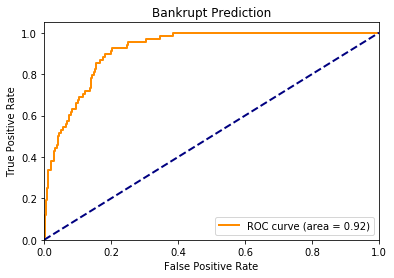

In [68]:
fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

Best F1 is 0.12398921832884097 at threshold = [0.96053694]


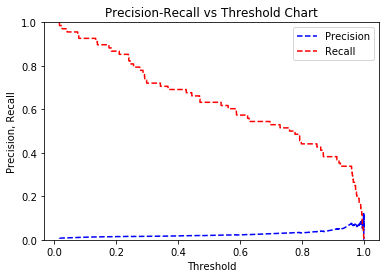

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

f1 = 2*(precision*recall)/(precision+recall)

best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')

In [70]:
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.99805   0.98801   0.99301     23353
         1.0    0.07591   0.33824   0.12399        68

    accuracy                        0.98612     23421
   macro avg    0.53698   0.66312   0.55850     23421
weighted avg    0.99538   0.98612   0.99048     23421



# Neural Network #

In [71]:
# Create a Multi-Layer Perceptron Classifier object
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (50, 50, 50, 50, 50),random_state=42)

In [72]:
# Create a Pipeline for mlp
dnn = Pipeline(steps = [
    ('classifier', mlp)
])

In [73]:
# Fit the pipeline on the training data
dnn.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('classifier',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(50, 50, 50, 50, 50),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [74]:
# Make predictions on test data
y_pred = dnn.predict(x_test)

In [75]:
# Calculate prediction accuracy on test data
test_acc = dnn.score(x_test, y_test)
test_acc

0.9961572947354937

In [76]:
print(classification_report(y_test, y_pred, digits=5))

precision    recall  f1-score   support

         0.0    0.99722   0.99893   0.99807     23353
         1.0    0.10714   0.04412   0.06250        68

    accuracy                        0.99616     23421
   macro avg    0.55218   0.52152   0.53029     23421
weighted avg    0.99464   0.99616   0.99536     23421



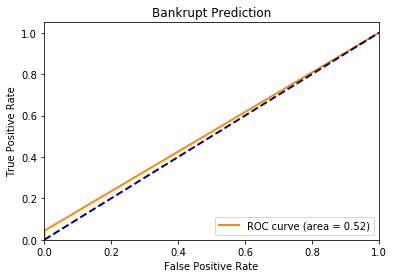

In [77]:
fpr,tpr,threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

# Exploratory Data Analysis #

In [78]:
#! pip install pandas-profiling

In [79]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(cm1)
# profile.to_file(outputfile = 'Profile.html')
# profile

In [80]:
cmcm.head()

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt
0,10001,"Transportation, Communications, Electric, Gas ...",0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0
1,10001,"Transportation, Communications, Electric, Gas ...",0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0
2,10001,"Transportation, Communications, Electric, Gas ...",0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0
3,10001,"Transportation, Communications, Electric, Gas ...",0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0
4,10001,"Transportation, Communications, Electric, Gas ...",0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.142209,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,

In [81]:
bankrupt = cmcm[cmcm['bankrupt']==1]
not_bankrupt = cmcm[cmcm['bankrupt']==0]

In [44]:
# for i in list(cmcm)[2:66]:
#     plt.figure(figsize=(8,5), dpi= 80)
#     sns.kdeplot(bankrupt[i], shade=True, color="pink", label="Bankrupt", alpha=.7)
#     sns.kdeplot(not_bankrupt[i], shade=True, color="orange", label="Not Bankrupt", alpha=.7)
# #     sns.kdeplot(DT_df['price'], shade=True, color="lightgreen", label="DT", alpha=.7)
#     plt.title('Density Plot of'+ f'{i}'+ 'by Bankrupt or not', fontsize=10)
#     plt.legend()